<a href="https://colab.research.google.com/github/1900690/yolo-bbox-area-caliculate/blob/main/area_caliculate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip -q install ultralytics  # install
from ultralytics import YOLO, checks, hub

checks()  # checks

Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/107.7 GB disk)


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


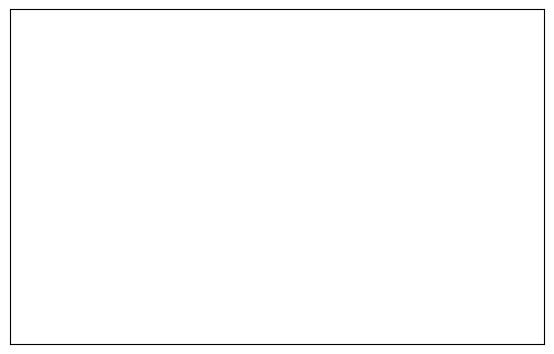

In [9]:
#@title 画像を取り込み { display-mode: "form" }
画像のアップロード方法を選択してください= 'サンプル画像で検出' #@param ["サンプル画像で検出", "画像をアップロード", "インカメラで画像を撮影", "アウトカメラで画像を撮影"]
#@markdown ※エラーが出た場合は、エラーが出なくなるまで実行し、カメラの許可を押してください

import os
import shutil
import datetime
dt_now = datetime.datetime.now()
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
from glob import glob
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import files



#表示用関数定義
def show_images_glob(images, figsize=(40,20), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(int(len(images) / columns + 1), columns, i + 1)
      plt.title(image[24:], loc='center',fontsize=20)
      plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False,bottom=False, left=False, right=False, top=False)
      plt.imshow(cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))

#インカメラ用関数定義
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.facingMode ='user';
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

#アウトカメラ用関数定義
def take_photo_out(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video:{facingMode:{exact:"environment"}}});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.facingMode ='environment';
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

if 画像のアップロード方法を選択してください== 'サンプル画像で検出':
    if os.path.exists('/content/photo.jpg'):
      os.remove('/content/photo.jpg')
    !wget -q https://github.com/1900690/yolo-bbox-area-caliculate/releases/download/strawberry_sample/itigo.jpg
    os.rename('/content/itigo.jpg','/content/photo.jpg')

    show_images_glob(['/content/photo.jpg'])


elif 画像のアップロード方法を選択してください== "画像をアップロード" :
    if os.path.exists('/content/photo.jpg'):
      os.remove('/content/photo.jpg')

    uploaded_file = files.upload()
    uploaded_file_name = next(iter(uploaded_file))
    os.rename(uploaded_file_name,'/content/photo.jpg')

    show_images_glob(['/content/photo.jpg'])

elif 画像のアップロード方法を選択してください== 'インカメラで画像を撮影':

    %cd -q '/content'

    from IPython.display import Image
    try:
      filename = take_photo()
      #title=dt_now.strftime('%Y%m%d_%H%M%S_000')

      #print('Saved to {}'.format(title+".jpg"))

      # Show the image which was just taken.
      #display(Image(filename))
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))

    show_images_glob(['/content/photo.jpg'])
else:

    %cd -q '/content'

    from IPython.display import Image
    try:
      filename = take_photo_out()
      #title=dt_now.strftime('%Y%m%d_%H%M%S_000')

      #print('Saved to {}'.format(title+".jpg"))

      # Show the image which was just taken.
      #display(Image(filename))
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      #print(str(err))
      print("")
    if not os.path.exists('/content/photo.jpg'):
        print("アウトカメラがありません")
    else:
      show_images_glob(['/content/photo.jpg'])

In [7]:
images

['/content/photo.jpg']

In [ ]:
from ultralytics.utils.plotting import Annotator
from ultralytics import YOLO
import cv2
import os
import tensorflow as tf
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd

model = YOLO('/content/itigo.pt')  # ★モデルを指定

if os.path.exists('/content/detect.txt'):
  os.remove('/content/detect.txt')
if os.path.exists('/content/myfile.txt'):
  os.remove('/content/myfile.txt')
if os.path.exists('/content/pickup.txt'):
  os.remove('/content/pickup.txt')

imgname='/content/itigo3.jpg'#★検出画像を指定

# Process the image
source = cv2.imread(imgname)
results = model(source,conf=0.25,iou=0.45)

# Extract results
annotator = Annotator(source, example=model.names)

for box in results[0].boxes.xyxy.cpu():
    width, height, area = annotator.get_bbox_dimension(box)
    datalist = [str(box[0].item())," ",str(box[1].item())," ",str(box[2].item())," ",str(box[3].item())," ",str(area.item()),"\n"]
    f = open('/content/myfile.txt', 'a')
    f.writelines(datalist)
    f.close()

#計算する座標データを読み込み
txt_file = pd.read_csv("/content/myfile.txt",header=None, sep=" ")
#大きいほうから〇個分を抽出
pickup_file=txt_file.nlargest(5, columns=4)#★検出個数を指定
# テキスト形式で出力
pickup_file.to_csv('/content/pickup.txt',header=False, index=False, sep=" ")

#書き込む画像を読み込み
im_original = Image.open(imgname)
image_height,image_width=np.array(im_original).shape[:2]

#書き込む座標データを読み込み
txt_file = pd.read_csv("/content/pickup.txt",header=None, sep=" ")
for annotation in range(len(txt_file)):
  draw = ImageDraw.Draw(im_original)
  x1=txt_file[0][annotation]
  y1=txt_file[1][annotation]
  x2=txt_file[2][annotation]
  y2=txt_file[3][annotation]
  draw.rectangle((x1, y1, x2, y2), outline=(0, 255, 0), width=5)

  im_original.save('/content/itigo1_after.jpg')


0: 384x640 113 strawberrys, 2369.3ms
Speed: 3.0ms preprocess, 2369.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict3
1 label saved to runs/detect/predict3/labels
